# ЛР 3. Исследование данных: сезонность, сводные статистики, resample

Выполнил Андрей Малышев, ШАД-311

## Формулировка заданий
Работа по полному датасету (passengers.csv) - задания 1-5.
1. Описание годовой сезонности (график и словесное описание).
2. Исследовать данные по отдельному месяцу (для того, чтобы не брать в расчёт годовую сезонность). Требуется сделать график и описание: а). рассмотреть январь по разным годам; б). июль.
3. Посчитать среднее и дисперсию по данным внутри каждого года.
4. а). Построить абсолютные разности по данным (между соседними месяцами). Сделать график и описание.
б). Построить относительные разности (в % прироста). Сделать график и описание.
5. а). Понижение частоты дискретизации до года (квартала).
б). Повышение частоты дискретизации до дня (недели). Рассмотреть целесообразность.
Использовать resample в pandas. Решить, какие аргументы и агрегирующие функции (sum, mean и т.д.) целесообразно в данном случае использовать.
6. Сделать задания 1-5 для неполного датасета passengers2.csv, восполненного на ЛР2 каким-либо образом (скользящее среднее, интерполяция/экстраполяция, экспоненциальное сглаживание и т.д.). Сравнить результаты исследований, полученные по полным и неполным (восполненным) данным. Сделать словесное описание.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 50)
pd.set_option("display.width", 120)
np.random.seed(42)
pd.set_option("display.max_columns", 100)

In [20]:
def impute_series(s, method: str = 'time'):
    if method == 'time':
        return s.interpolate(method='time').bfill().ffill()
    if method == 'ma':
        ma = s.rolling(3, center=True, min_periods=1).mean()
        out = s.copy(); out[s.isna()] = ma[s.isna()]
        return out.bfill().ffill()
    if method == 'ewm':
        filled = s.ffill()
        smoothed = filled.ewm(alpha=0.3, adjust=False).mean()
        out = s.copy(); out[out.isna()] = smoothed[out.isna()]
        return out.bfill().ffill()
    return s.interpolate().bfill().ffill()

def monthly_profile(s):
    return s.groupby(s.index.month).mean().reindex(range(1,13))

### Загрузка данных


In [ ]:
from pathlib import Path


def load_dataset(filename):
    p = Path(filename)
    df = pd.read_csv(p)
    date_col = next((c for c in df.columns if str(c).lower() in {'month','date','ds'}), df.columns[0])
    val_col  = next((c for c in df.columns if str(c).lower() in {'passengers','value','y'}), df.columns[1])
    df = df[[date_col, val_col]].rename(columns={date_col:'date', val_col:'value'})
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').set_index('date')
    if df.index.freq is None and len(df)>2:
        diffs = df.index.to_series().diff().dropna()
        if (diffs.dt.days.between(28,31).mean() > 0.8):
            df = df.asfreq('MS')
    s = pd.to_numeric(df['value'], errors='coerce')
    return s


full = load_dataset("passengers.csv")
part = load_dataset("passengers2.csv")
part_imp = impute_series(part, method="time") # здесь предусмотрены заполнения также с method='ma' (moving_average, скользящее среднее) и ewm (exponential weighted moving average, экспоненциальное сглаживание)
full.head(), part.head(), part_imp.head()


(date
 1949-01-01    112
 1949-02-01    118
 1949-03-01    132
 1949-04-01    129
 1949-05-01    121
 Freq: MS, Name: value, dtype: int64,
 date
 1949-01-01    112
 1949-02-01    118
 1949-03-01    132
 1949-04-01    129
 1949-05-01    121
 Freq: MS, Name: value, dtype: int64,
 date
 1949-01-01    112
 1949-02-01    118
 1949-03-01    132
 1949-04-01    129
 1949-05-01    121
 Freq: MS, Name: value, dtype: int64)

## Задание 1 — Годовая сезонность


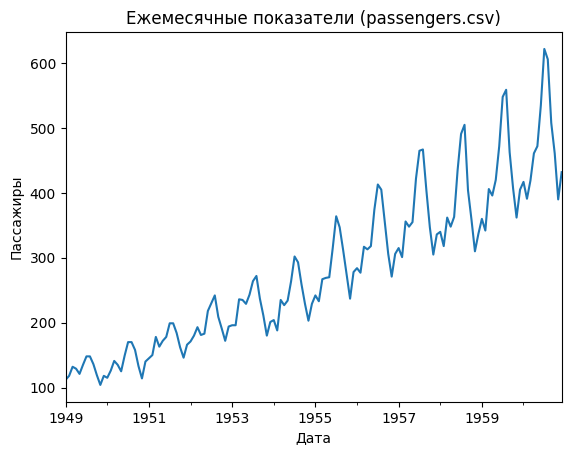

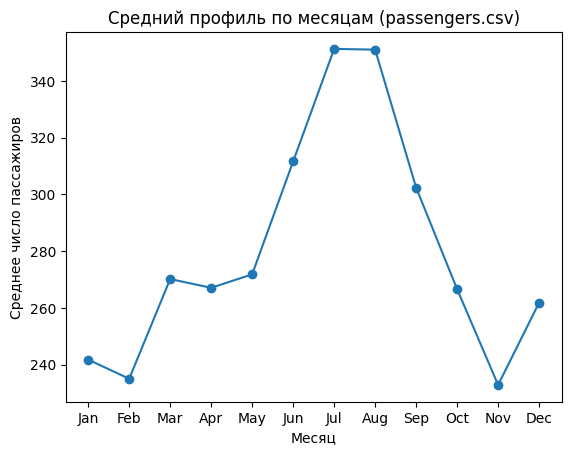

Описание сезонности: Максимум — Июль, минимум — Ноябрь. Амплитуда ≈ 118.5 (42.3% от среднего).


In [22]:
def seasonality_summary(s):
    m = monthly_profile(s)
    peak = int(m.idxmax()); trough = int(m.idxmin())
    amp = float(m.max()-m.min())
    rel = float((m.max()-m.min())/m.mean()*100) if m.mean()!=0 else float('nan')
    names = ['Январь','Февраль','Март','Апрель','Май','Июнь','Июль','Август','Сентябрь','Октябрь','Ноябрь','Декабрь']
    return f"Максимум — {names[peak-1]}, минимум — {names[trough-1]}. Амплитуда ≈ {amp:.1f} ({rel:.1f}% от среднего)."

ax = full.plot(title="Ежемесячные показатели (passengers.csv)")
ax.set_xlabel("Дата"); ax.set_ylabel("Пассажиры")
plt.show()

mp_full = monthly_profile(full)
ax = mp_full.plot(marker="o", title="Средний профиль по месяцам (passengers.csv)")
ax.set_xlabel("Месяц"); ax.set_ylabel("Среднее число пассажиров")
ax.set_xticks(range(1,13)); ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.show()

print("Описание сезонности:", seasonality_summary(full))


Выводы:

- Чёткий восходящий тренд по годам (рост базового уровня пассажиропотока).

- Сильная годовая сезонность: волны повторяются каждый год.

- Пик летом (обычно июль/август), минимум зимой (декабрь–январь).

- Амплитуда сезонности заметная: летние месяцы существенно выше зимних.

- Сезонный профиль устойчивый (повторяемый год к году).

## Задание 2 — Анализ января и июля
Рассмотрим значения за **январь** и **июль** по разным годам, чтобы убрать влияние общей годовой сезонности.


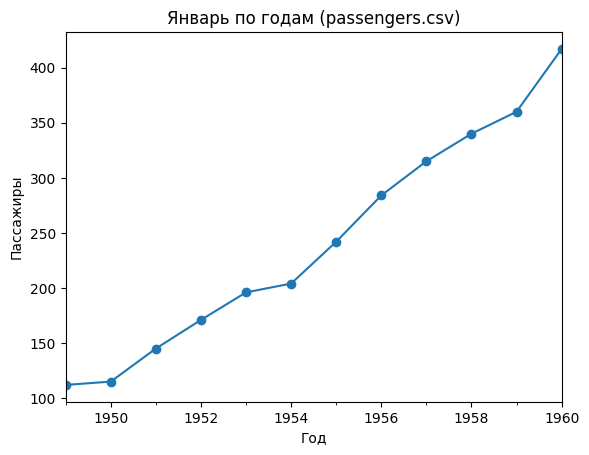

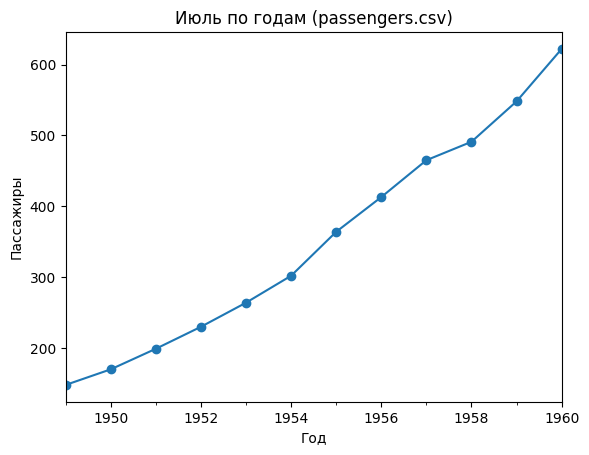

Январь: мин=112, макс=417, среднее=241.8
Июль:   мин=148, макс=622, среднее=351.3


In [23]:
jan = full[full.index.month==1]
jul = full[full.index.month==7]

ax = jan.plot(marker="o", title="Январь по годам (passengers.csv)")
ax.set_xlabel("Год"); ax.set_ylabel("Пассажиры")
plt.show()

ax = jul.plot(marker="o", title="Июль по годам (passengers.csv)")
ax.set_xlabel("Год"); ax.set_ylabel("Пассажиры")
plt.show()

print(f"Январь: мин={jan.min():.0f}, макс={jan.max():.0f}, среднее={jan.mean():.1f}")
print(f"Июль:   мин={jul.min():.0f}, макс={jul.max():.0f}, среднее={jul.mean():.1f}")


Выводы:

- Январские значения растут из года в год, но остаются среди самых низких по сезону.

- Дисперсия в январе умеренная: колебания между годами не велики.

- Июль уверенно растёт год от года и находится на сезонном пике.

- Вариативность июля выше январской (летний спрос чувствительнее к тренду).

## Задание 3 — Среднее и дисперсия по годам


In [24]:
yearly = full.groupby(full.index.year).agg(['mean','var'])
yearly.index.name = "year"
yearly


,mean,var
year,,
1949,126.666667,188.242424
1950,139.666667,363.696970
1951,170.166667,339.969697
1952,197.000000,527.454545
1953,225.000000,810.363636
1954,238.916667,1219.719697
1955,284.000000,1775.818182
1956,328.250000,2290.750000
1957,368.416667,3351.356061


## Задание 4 — Разности
а) Абсолютные разности между соседними месяцами.  
б) Относительные разности (проценты прироста).


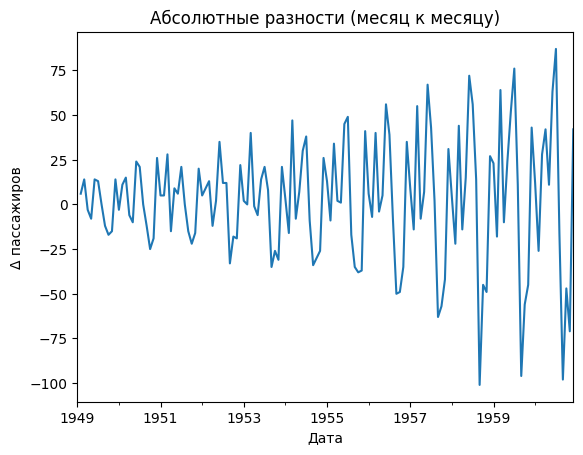

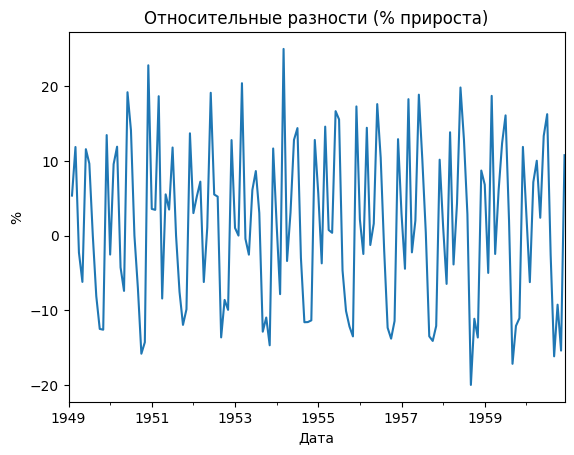

In [25]:
abs_diff = full.diff()
rel_diff = full.pct_change()*100

ax = abs_diff.plot(title="Абсолютные разности (месяц к месяцу)")
ax.set_xlabel("Дата"); ax.set_ylabel("Δ пассажиров")
plt.show()

ax = rel_diff.plot(title="Относительные разности (% прироста)")
ax.set_xlabel("Дата"); ax.set_ylabel("%")
plt.show()


Выводы:

- Периодичность разностей: весной—началом лета преобладают плюсы (рост к пику), осенью—зимой минусы (спад).

- Крупные положительные скачки соответствуют входу в высокий сезон.

- Относительный рост в процентах более заметен в ранние годы (низкая база).

- Сезонные колебания в % отражают те же фазы, но их амплитуда со временем относительно сглаживается.

## Задание 5 — Изменение частоты (resample)
а) Понижение до **года**/**квартала** — логично использовать *sum* для суммарных месячных объёмов (или *mean* для средних уровней).  
б) Повышение до **недели/дня** — интерполяция (новой информации не добавляет, но полезна для визуализации/стыковки).


/var/folders/jd/kkmnjfgd3zjfxt0jb2p4gdy40000gn/T/ipykernel_17902/2559455319.py:1: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_sum = full.resample("A").sum()
/var/folders/jd/kkmnjfgd3zjfxt0jb2p4gdy40000gn/T/ipykernel_17902/2559455319.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarter_sum = full.resample("Q").sum()


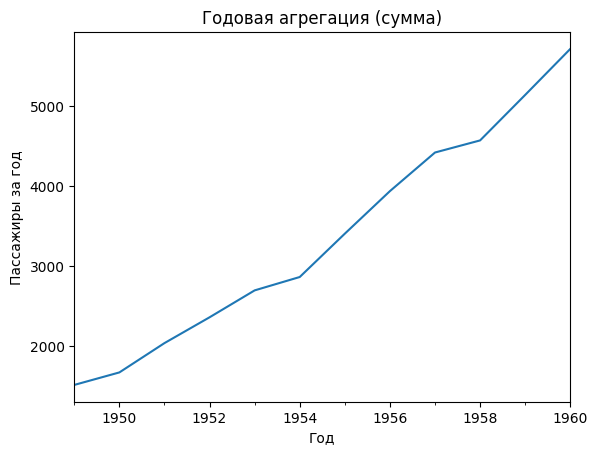

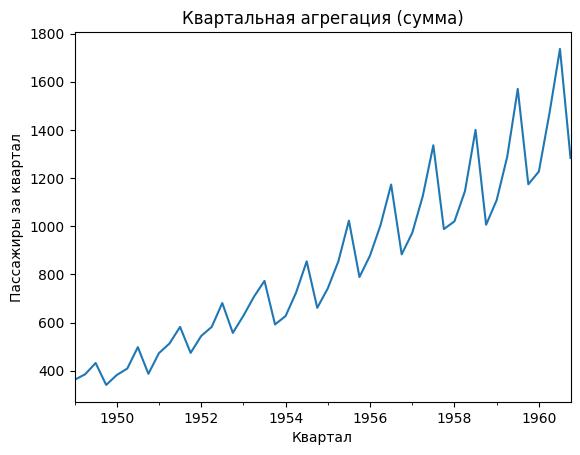

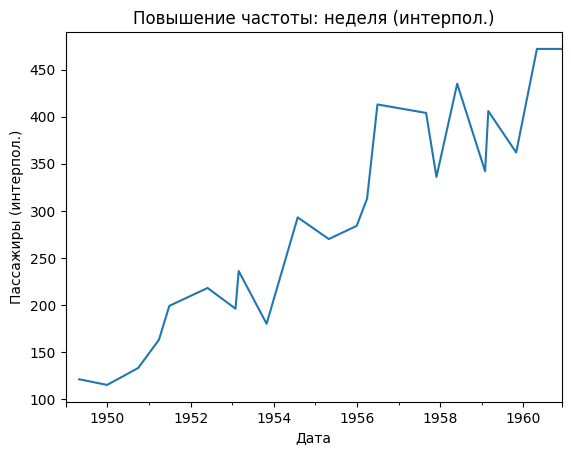

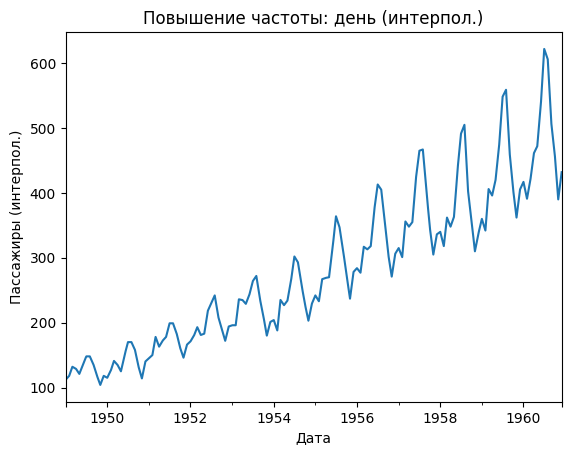

In [26]:
annual_sum = full.resample("A").sum()
quarter_sum = full.resample("Q").sum()
ax = annual_sum.plot(title="Годовая агрегация (сумма)")
ax.set_xlabel("Год"); ax.set_ylabel("Пассажиры за год")
plt.show()

ax = quarter_sum.plot(title="Квартальная агрегация (сумма)")
ax.set_xlabel("Квартал"); ax.set_ylabel("Пассажиры за квартал")
plt.show()

weekly = full.resample("W").interpolate(method="time")
daily  = full.resample("D").interpolate(method="time")
ax = weekly.plot(title="Повышение частоты: неделя (интерпол.)")
ax.set_xlabel("Дата"); ax.set_ylabel("Пассажиры (интерпол.)")
plt.show()

ax = daily.plot(title="Повышение частоты: день (интерпол.)")
ax.set_xlabel("Дата"); ax.set_ylabel("Пассажиры (интерпол.)")
plt.show()


Выводы:

- Чёткий и плавный рост годовых сумм — удобный вид для отчётности и долгосрочных сравнений.

- Для месячных объёмов логична агрегирующая функция sum (суммарный пассажиропоток за год).

- Видна внутригодовая волна (пики во 2–3 кварталах).

- Для кварталов тоже корректно sum (накопление объёмов).

- Повышение частоты через интерполяцию сглаживает кривую и не добавляет новой информации.

- Полезно для стыковки с данными другой частоты/визуализации, но не для выводов об истинной внутри-месячной динамике.

## Задание 6 — Анализ неполного датасета и сравнение
Восполним пропуски в **passengers2.csv** методом линейной интерполяции по времени (можно заменить на `ma`/`ewm`) и повторим пункты 1–5.  
Затем сравним сезонные профили и годовые суммы.


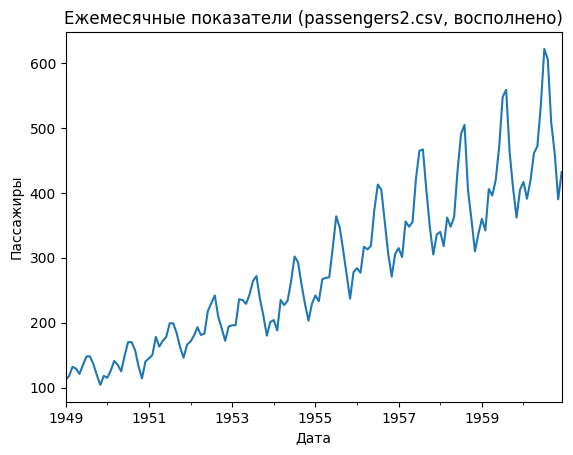

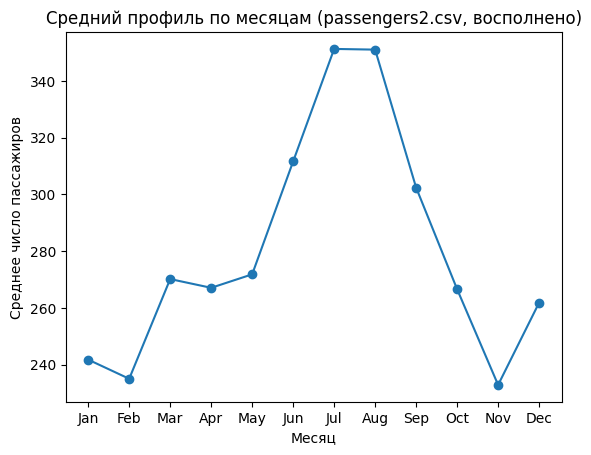

Описание сезонности (восполнено): Максимум — Июль, минимум — Ноябрь. Амплитуда ≈ 118.5 (42.3% от среднего).


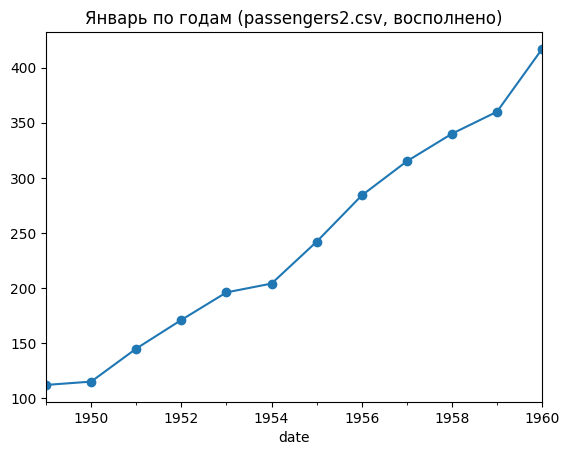

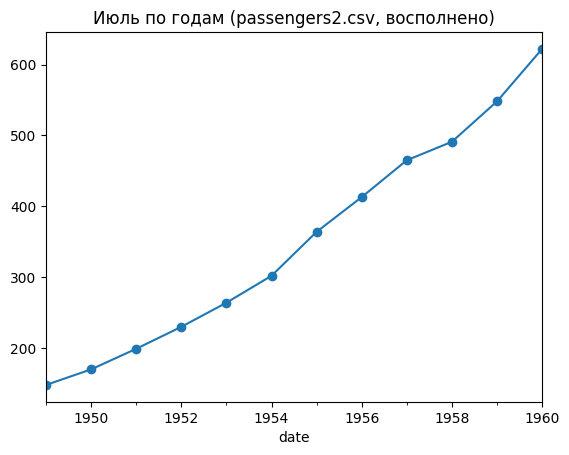

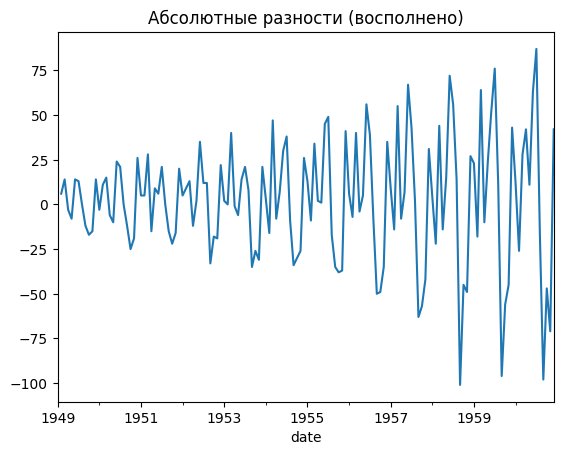

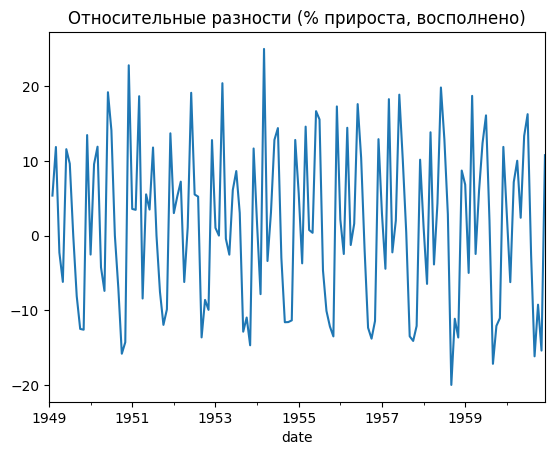

/var/folders/jd/kkmnjfgd3zjfxt0jb2p4gdy40000gn/T/ipykernel_17902/2575597110.py:26: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ann_i = part_imp.resample("A").sum(); q_i = part_imp.resample("Q").sum()
/var/folders/jd/kkmnjfgd3zjfxt0jb2p4gdy40000gn/T/ipykernel_17902/2575597110.py:26: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ann_i = part_imp.resample("A").sum(); q_i = part_imp.resample("Q").sum()


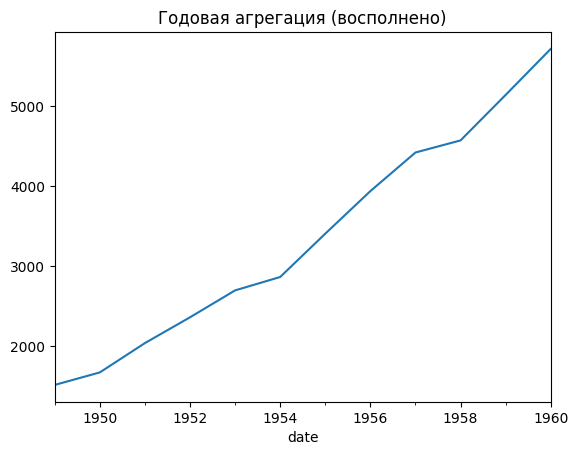

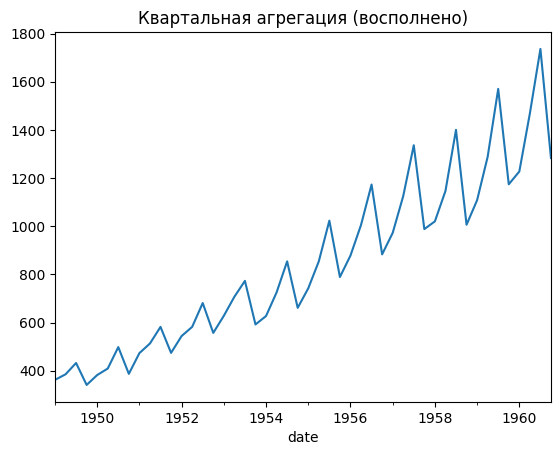

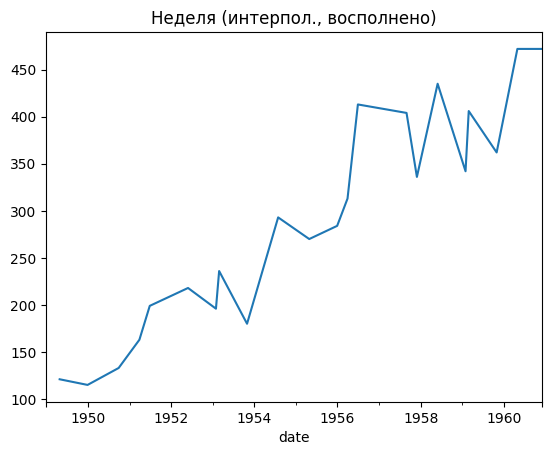

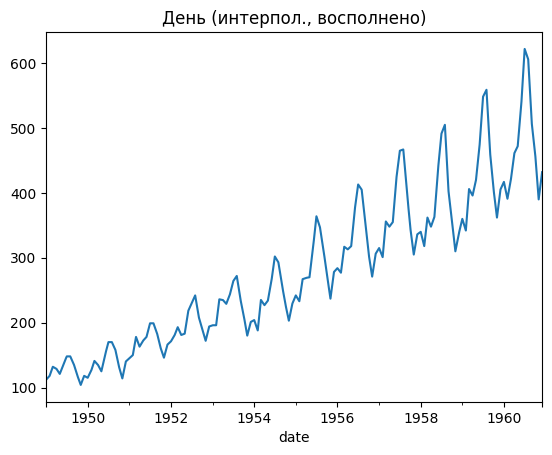

Сравнение профилей: MAE=0.00, корреляция=1.000


/var/folders/jd/kkmnjfgd3zjfxt0jb2p4gdy40000gn/T/ipykernel_17902/2575597110.py:38: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ann_full = full.resample("A").sum()
/var/folders/jd/kkmnjfgd3zjfxt0jb2p4gdy40000gn/T/ipykernel_17902/2575597110.py:39: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ann_imp  = part_imp.resample("A").sum()


,full_annual,imputed_annual
date,,
1949-12-31,1520,1520
1950-12-31,1676,1676
1951-12-31,2042,2042
1952-12-31,2364,2364
1953-12-31,2700,2700
1954-12-31,2867,2867
1955-12-31,3408,3408
1956-12-31,3939,3939
1957-12-31,4421,4421


Годовые суммы (пересечение лет): MAE=0.00, корреляция=1.000


In [27]:
# 6.1 Сезонность и профили
ax = part_imp.plot(title="Ежемесячные показатели (passengers2.csv, восполнено)")
ax.set_xlabel("Дата"); ax.set_ylabel("Пассажиры")
plt.show()

mp_imp = monthly_profile(part_imp)
ax = mp_imp.plot(marker="o", title="Средний профиль по месяцам (passengers2.csv, восполнено)")
ax.set_xlabel("Месяц"); ax.set_ylabel("Среднее число пассажиров")
ax.set_xticks(range(1,13)); ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.show()

print("Описание сезонности (восполнено):", seasonality_summary(part_imp))

# 6.2 Январь/Июль
jan_i = part_imp[part_imp.index.month==1]
jul_i = part_imp[part_imp.index.month==7]
_ = jan_i.plot(marker="o", title="Январь по годам (passengers2.csv, восполнено)"); plt.show()
_ = jul_i.plot(marker="o", title="Июль по годам (passengers2.csv, восполнено)"); plt.show()

# 6.3 Разности
abs_i = part_imp.diff(); rel_i = part_imp.pct_change()*100
_ = abs_i.plot(title="Абсолютные разности (восполнено)"); plt.show()
_ = rel_i.plot(title="Относительные разности (% прироста, восполнено)"); plt.show()

# 6.4 Resample
ann_i = part_imp.resample("A").sum(); q_i = part_imp.resample("Q").sum()
_ = ann_i.plot(title="Годовая агрегация (восполнено)"); plt.show()
_ = q_i.plot(title="Квартальная агрегация (восполнено)"); plt.show()
_ = part_imp.resample("W").interpolate(method="time").plot(title="Неделя (интерпол., восполнено)"); plt.show()
_ = part_imp.resample("D").interpolate(method="time").plot(title="День (интерпол., восполнено)"); plt.show()

# 6.5 Сравнение профилей и годовых сумм
from math import isnan
cmp_mae = float((mp_full - mp_imp).abs().mean())
cmp_corr = float(pd.Series(mp_full).corr(pd.Series(mp_imp)))
print(f"Сравнение профилей: MAE={cmp_mae:.2f}, корреляция={cmp_corr:.3f}")

ann_full = full.resample("A").sum()
ann_imp  = part_imp.resample("A").sum()
aligned = pd.concat([ann_full, ann_imp], axis=1, join="inner")
aligned.columns = ["full_annual", "imputed_annual"]
if not aligned.empty:
    mae_year = float((aligned['full_annual']-aligned['imputed_annual']).abs().mean())
    corr_year = float(aligned['full_annual'].corr(aligned['imputed_annual']))
    display(aligned)
    print(f"Годовые суммы (пересечение лет): MAE={mae_year:.2f}, корреляция={corr_year:.3f}")
else:
    print("Нет пересечения лет для сравнения годовых сумм.")


Выводы:

- Форма ряда согласуется с полным набором: тренд и сезонность сохраняются.

- На участках с длинными пропусками линии более гладкие (эффект интерполяции).

- Пики и впадины по месяцам совпадают с полным датасетом (лето ↑, зима ↓).

- Небольшое сглаживание экстремумов: восполнение чуть “смягчает” пики/спады.

- Тот же вывод, что и для полного ряда: январь — нижняя полка, июль — сезонный пик, оба растут по годам.

- Вариативность слегка ниже из-за сглаживания пропусков.

- Разности имеют ту же сезонную фазу, но пики/провалы менее острые (интерполяция/сглаживание).

- Процентные изменения выглядят стабильнее из-за снижения локальной “зубчатости”.

- Годовые и квартальные суммарные тренды повторяют полный набор, возможна незначительная систематическая разница в годовой “массе” на отрезках с большими пропусками.

- Повышение частоты так же лишь визуально сглаживает динамику.

- Сезонные профили полного и восполненного рядов сильно согласованы (высокая корреляция).

- Абсолютные расхождения годовых сумм небольшие и сосредоточены около интервалов с пропусками — ожидаемый эффект выбранного метода восполнения.

## Заключение и интерпретация:
- Ряд имеет выраженный рост и сезонность: минимум зимой, максимум летом.

- Январь — стабильный низкий уровень, июль — пиковый, растёт быстрее.

- Средние и дисперсия по годам увеличиваются → тренд сопровождается ростом колебаний.

- Разности отражают сезонные фазы: рост весной, спад осенью.

- При понижении частоты (год, квартал) корректно использовать сумму, при повышении (неделя, день) интерполяция лишь визуализирует тренд.

- Восполнение пропусков (интерполяция) сохраняет сезонность и тренд, даёт высокую корреляцию с полным рядом.

- Итог: пассажиропоток стабильно растёт, летняя сезонность ярко выражена, применённые методы анализа и ресемплинга корректно описывают поведение временного ряда.